<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Solving-just-one-instance-to-check-if-it-works-properly" data-toc-modified-id="Solving-just-one-instance-to-check-if-it-works-properly-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Solving just one instance to check if it works properly</a></span></li><li><span><a href="#Sampling-solutions" data-toc-modified-id="Sampling-solutions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sampling solutions</a></span><ul class="toc-item"><li><span><a href="#Original-graph-without-correction" data-toc-modified-id="Original-graph-without-correction-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Original graph without correction</a></span></li></ul></li><li><span><a href="#Run-complete-algorithm" data-toc-modified-id="Run-complete-algorithm-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Run complete algorithm</a></span></li></ul></li></ul></div>

In [1]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size = 12)
rc('xtick', labelsize = 12)
rc('ytick', labelsize = 12)
rc('figure', figsize = (8, 4))

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from amod_ed.contractivity_v3 import viz_costs, _construct_problem
from amod_ed.contractivity_v3 import sample_solutions, run_algorithm
import cvxpy as cp
import networkx as nx

import pandas as pd

from amod_ed.contractivity_v3 import plot_results_run, compute_error_KKT, get_d_values

from amod_ed.contractivity_v3 import get_new_r, get_edge_flow, get_flow_edge_od

# Description

We want to find a "pathological case" that is good for manual study. 

# Load

The characteristics of the graph are loaded from Excel files. 

In [55]:
edges = pd.read_excel('cost_edges_3.xlsx')
inv_edges = pd.read_excel('inv_demand_3.xlsx')

In [56]:
edges

,origin,destination,phi,k
0,1,2,1,3
1,2,1,1,3
2,1,3,1,3
3,3,1,1,3
4,2,3,1,3
5,3,2,1,3


In [57]:
inv_edges = inv_edges.iloc[:2,:]

In [58]:
inv_edges

,origin,destination,phi,k,shift
0,1,2,1,4,10
1,2,1,3,3,60


## Solving just one instance to check if it works properly

The below builds the optimization problem. 

In [59]:
correct = False

In [60]:
"""
Returns
-------
f_p: cvxpy.Variable
    The flow for each commodity on each edge
f_r: cvxpy.Variable
    The rebalancing flow on each edge
r: cvxpy.Parameter
    The rebalancing guess for each node
d_var: cvxpy.Variable
    The demand for each each
prob: cvxpy.Problem
    The optimization problem
map_comps: dict
    A map linking components of f_p to the edges and inv edges
map_edges: dict
    A map linking edges to components of f_p
costs_dict: dict
    Dict containing the cost for each edge
inv_demand_dict: dict
    The inverse demand cost for each od pair
G: nx.DiGraph
    Graph representing the network
nodes: list
    list of nodes
"""
f_p, f_r, r, d_var, prob, map_comps, map_edges,\
 costs_dict, inv_d_dict, G, nodes = _construct_problem(edges, inv_edges, correct = correct)

Specify a value of the rebalancing parameter

In [61]:
r_new = [0, 0, 0]
r.value = r_new

You can then solve the problem. 

In [62]:
prob.solve(solver = cp.GUROBI)

-502.03586155810837

Check the status. 

In [63]:
prob.status

'optimal'

Therefore, the below function helps in analyzing and decomposing edge by edge for the passenger flow. 

In [64]:
get_edge_flow(f_p, map_edges)

{(1, 2): 5.824041140884746,
 (1, 3): 4.179325058881762,
 (2, 1): 5.790806459158919,
 (2, 3): 4.13465942401789,
 (3, 1): 4.13465942401789,
 (3, 2): 4.179325058881759}

In [65]:
get_d_values(inv_edges, d_var)

{(1, 2): 10.003366065784562, (2, 1): 9.925465760358023}

In [66]:
get_flow_edge_od(map_comps, f_p)

{(1, 2): {(1, 2): 5.824041096216838, (2, 1): 4.466790778042142e-08},
 (1, 3): {(1, 2): 4.179324969567724, (2, 1): 8.931403799488713e-08},
 (2, 1): {(1, 2): 4.0945197131851134e-08, (2, 1): 5.790806418213721},
 (2, 3): {(1, 2): 8.187358988874088e-08, (2, 1): 4.1346593421443005},
 (3, 1): {(1, 2): 8.187358987485102e-08, (2, 1): 4.1346593421443005},
 (3, 2): {(1, 2): 4.179324969567724, (2, 1): 8.931403542796204e-08}}

In [67]:
kkt_rel_error = compute_error_KKT(G, costs_dict, inv_d_dict, inv_edges, map_comps, f_p)

In [68]:
kkt_rel_error

{(1, 2): [0.9993227447005105, 0.999113390526133],
 (2, 1): [1.000018479691108, 1.0000271558323564]}

We can also compute directly the new rebalancing guess. 

In [69]:
get_new_r(f_p, map_edges, nodes)

[-0.07790031658969987, 0.07790031658969647, 1.627070670578469e-15]

In [103]:
np.random.rand(4,4)

array([[0.80074457, 0.96826158, 0.31342418, 0.69232262],
       [0.87638915, 0.89460666, 0.08504421, 0.03905478],
       [0.16983042, 0.8781425 , 0.09834683, 0.42110763],
       [0.95788953, 0.53316528, 0.69187711, 0.31551563]])

## Sampling solutions

### Original graph without correction

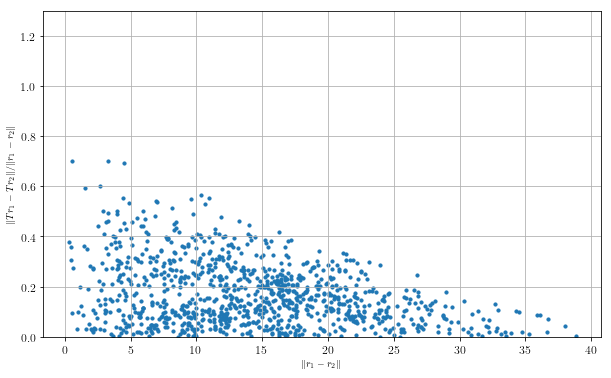

In [70]:
Tr, r_, dT, dr = sample_solutions(edges, inv_edges, nsamples = 1000, seed=5, name = 'contractivity_1', save = False)

## Run complete algorithm

Currently we see no "weird behavior". Maybe we should change the characteristics of the edges?

In [78]:
edges

,origin,destination,phi,k
0,1,2,2,2
1,2,1,2,1
2,1,3,2,1
3,3,1,2,2
4,2,3,3,1
5,3,2,2,1


In [77]:
edges['phi']=np.random.randint(1,4, len(edges))
edges['k'] = np.random.randint(1,4,len(edges))

In [81]:
r_tot = run_algorithm(edges, inv_edges, nsolutions = 10, seed = 1, max_iter = 100)

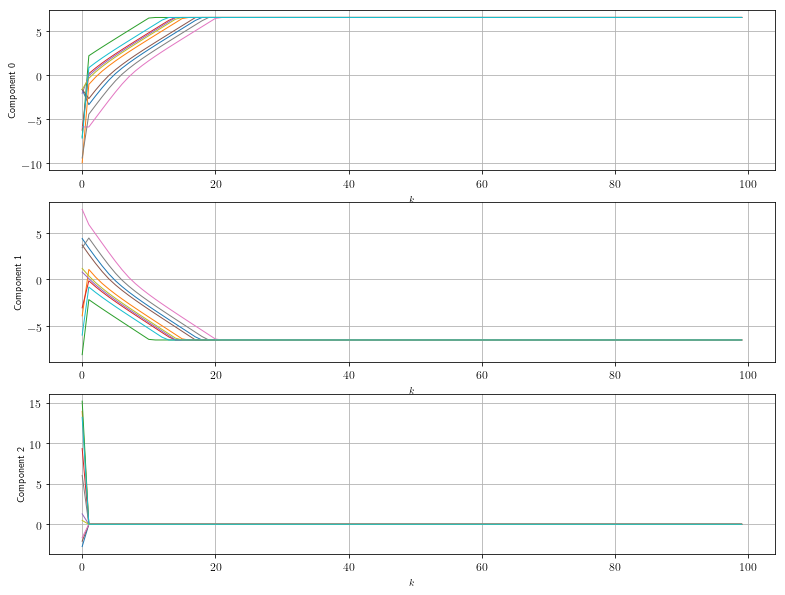

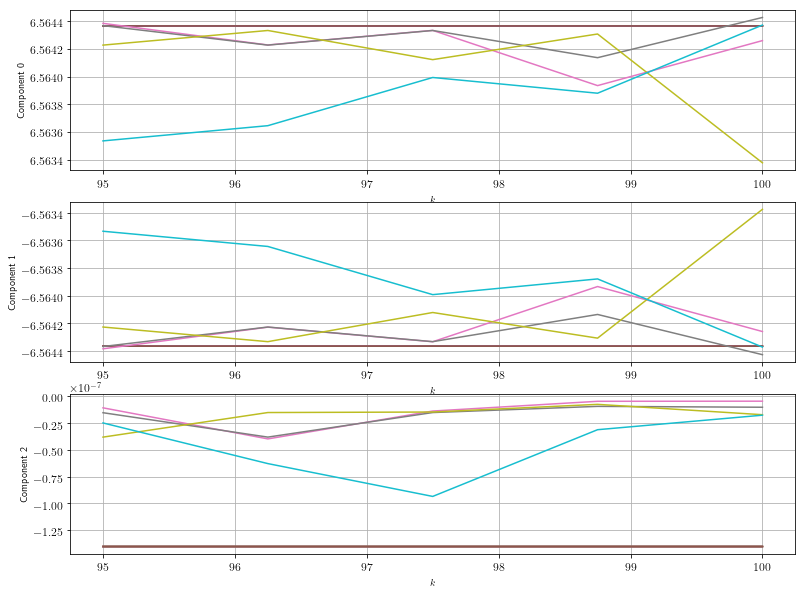

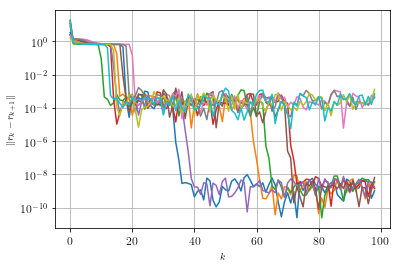

In [82]:
plot_results_run(r_tot)

choice of norm: we see that by fixing one component, the others still evolve but the norm of the difference is unchanged (or nearly). would that change if we actually "forget" the fixed component? 

Also, i started thinking about this problem and went back to the 2node multiple link case -- useful just to formalize everything I have in mind I think

In [88]:
for r in r_tot:
    print("new R")
    for i in range(6):
        print(r[i], np.linalg.norm(r[i]-r[i+1]))

new R
[-1.65955991  4.40648987 -2.74692996] 3.397710361000823
[-3.36917994e+00  3.36918008e+00 -1.42087831e-07] 1.3922045243972576
[-2.38474273e+00  2.38474278e+00 -4.93559134e-08] 1.3273976616755603
[-1.44613085e+00  1.44613088e+00 -2.41066651e-08] 1.2193211268188886
[-5.83940597e-01  5.83940658e-01 -6.14801639e-08] 1.063072008599301
[ 1.67764804e-01 -1.67764793e-01 -1.16905753e-08] 0.8944941790101322
new R
[-9.9977125  -3.95334855 13.95106105] 17.30960989902007
[-1.06329498e+00  1.06329397e+00  1.01144126e-06] 1.1571244280850204
[-2.45083928e-01  2.45083958e-01 -3.02130846e-08] 0.984951733264795
[ 4.51382108e-01 -4.51382104e-01 -4.15345488e-09] 0.8560565652428022
[ 1.05670552e+00 -1.05670549e+00 -2.76692008e-08] 0.7860640570253348
[ 1.61253674e+00 -1.61253673e+00 -1.00296406e-08] 0.7422264441872296
new R
[-7.06488218 -8.1532281  15.21811029] 18.785334598709447
[ 2.20286439e+00 -2.20286532e+00  9.36331942e-07] 0.709012107497137
[ 2.70421215e+00 -2.70421210e+00 -5.61930989e-08] 0.68886

Here we see that the third component of r is zero while the two others basically evolve. We see the evolution is very close to showing a constant of 1. 